In [2]:
# Credit Card Fraud Detection
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# Load Data
df = pd.read_csv('creditcard.csv')

In [3]:
# Feature Scaling (Log transform "Amount")
df["Amount_log"] = np.log1p(df["Amount"])
df.drop(columns=["Amount"], inplace=True)

# Define Features & Target
X = df.drop(columns=["Class"])  # Features
y = df["Class"]  # Target (0 = Non-Fraud, 1 = Fraud)

# Train-Test Split (Before SMOTE)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [4]:
# Check Class Distribution Before SMOTE
print("Before SMOTE:", Counter(y_train))

# Apply SMOTE only to Training Data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Check Class Distribution After SMOTE
print("After SMOTE:", Counter(y_train_smote))

Before SMOTE: Counter({0: 227451, 1: 394})
After SMOTE: Counter({0: 227451, 1: 227451})


In [ ]:
# Initialize Models
rf_model = RandomForestClassifier(n_estimators=150, max_depth=20, random_state=42)

# Add Regularization to XGBoost to prevent overfitting
xgb_model = XGBClassifier(
    n_estimators=100, max_depth=10, random_state=42, 
    use_label_encoder=False, eval_metric="logloss",
    reg_lambda=10,  # L2 Regularization (Ridge)
    reg_alpha=5      # L1 Regularization (Lasso)
)

# Train Models
rf_model.fit(X_train_smote, y_train_smote)
xgb_model.fit(X_train_smote, y_train_smote)

/opt/anaconda3/envs/hacklytics/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:50:44] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1738880277541/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [6]:
# Make Predictions
rf_pred = rf_model.predict(X_test)
xgb_pred = xgb_model.predict(X_test)

# Probability Predictions for ROC-AUC
rf_proba = rf_model.predict_proba(X_test)[:, 1]
xgb_proba = xgb_model.predict_proba(X_test)[:, 1]


In [7]:
# Evaluate Models
print("\n🎯 **Random Forest Results**")
print("Confusion Matrix:\n", confusion_matrix(y_test, rf_pred))
print("Classification Report:\n", classification_report(y_test, rf_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, rf_proba))

print("\n🚀 **XGBoost Results**")
print("Confusion Matrix:\n", confusion_matrix(y_test, xgb_pred))
print("Classification Report:\n", classification_report(y_test, xgb_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, xgb_proba))


🎯 **Random Forest Results**
Confusion Matrix:
 [[56839    25]
 [   17    81]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.76      0.83      0.79        98

    accuracy                           1.00     56962
   macro avg       0.88      0.91      0.90     56962
weighted avg       1.00      1.00      1.00     56962

ROC-AUC Score: 0.9843648612371229

🚀 **XGBoost Results**
Confusion Matrix:
 [[56844    20]
 [   14    84]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.81      0.86      0.83        98

    accuracy                           1.00     56962
   macro avg       0.90      0.93      0.92     56962
weighted avg       1.00      1.00      1.00     56962

ROC-AUC Score: 0.9880199301161094


In [8]:
# Cross-Validation Scores
rf_cv = cross_val_score(rf_model, X_train_smote, y_train_smote, cv=5, scoring='roc_auc')
xgb_cv = cross_val_score(xgb_model, X_train_smote, y_train_smote, cv=5, scoring='roc_auc')

print("\n📊 **Cross-Validation AUC Scores:**")
print(f"Random Forest: {rf_cv.mean():.5f}")
print(f"XGBoost: {xgb_cv.mean():.5f}")


/opt/anaconda3/envs/hacklytics/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:37:00] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1738880277541/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/hacklytics/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:37:01] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1738880277541/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/hacklytics/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:37:02] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1738880277541/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/hacklytics/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:37:03] WARNING: /Users/runner/minif


📊 **Cross-Validation AUC Scores:**
Random Forest: 1.00000
XGBoost: 0.99999


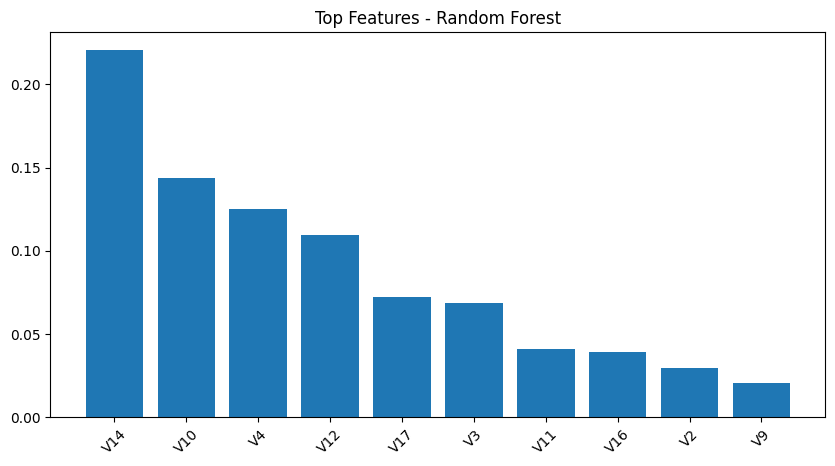

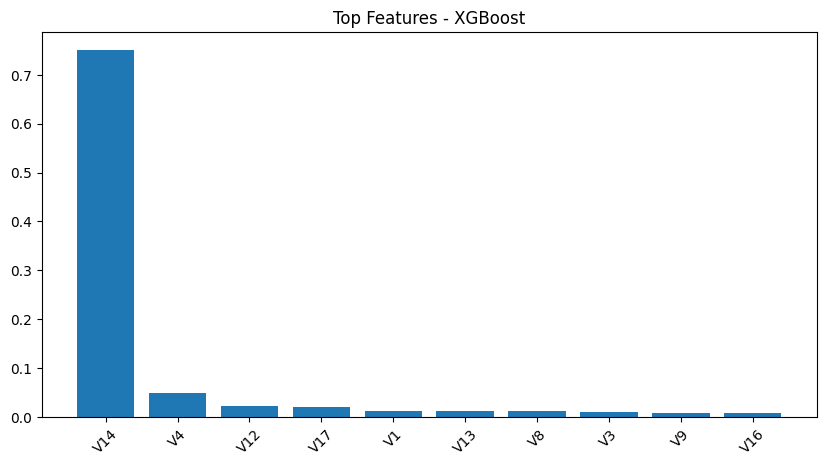

In [9]:
# Plot Feature Importance
def plot_feature_importance(model, title):
    importances = model.feature_importances_
    sorted_indices = np.argsort(importances)[::-1]
    
    plt.figure(figsize=(10, 5))
    plt.bar(range(10), importances[sorted_indices[:10]], align="center")
    plt.xticks(range(10), np.array(X.columns)[sorted_indices[:10]], rotation=45)
    plt.title(title)
    plt.show()

plot_feature_importance(rf_model, "Top Features - Random Forest")
plot_feature_importance(xgb_model, "Top Features - XGBoost")

In [10]:
# Threshold Tuning - Adjust for Lower False Negatives
threshold = 0.40  # Lower threshold for better fraud detection
rf_pred_adj = (rf_proba >= threshold).astype(int)
xgb_pred_adj = (xgb_proba >= threshold).astype(int)

print("\n🔧 **Random Forest (Threshold 0.40) Results**")
print("Confusion Matrix:\n", confusion_matrix(y_test, rf_pred_adj))
print("Classification Report:\n", classification_report(y_test, rf_pred_adj))

print("\n🔧 **XGBoost (Threshold 0.40) Results**")
print("Confusion Matrix:\n", confusion_matrix(y_test, xgb_pred_adj))
print("Classification Report:\n", classification_report(y_test, xgb_pred_adj))


🔧 **Random Forest (Threshold 0.40) Results**
Confusion Matrix:
 [[56830    34]
 [   14    84]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.71      0.86      0.78        98

    accuracy                           1.00     56962
   macro avg       0.86      0.93      0.89     56962
weighted avg       1.00      1.00      1.00     56962


🔧 **XGBoost (Threshold 0.40) Results**
Confusion Matrix:
 [[56840    24]
 [   14    84]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.78      0.86      0.82        98

    accuracy                           1.00     56962
   macro avg       0.89      0.93      0.91     56962
weighted avg       1.00      1.00      1.00     56962



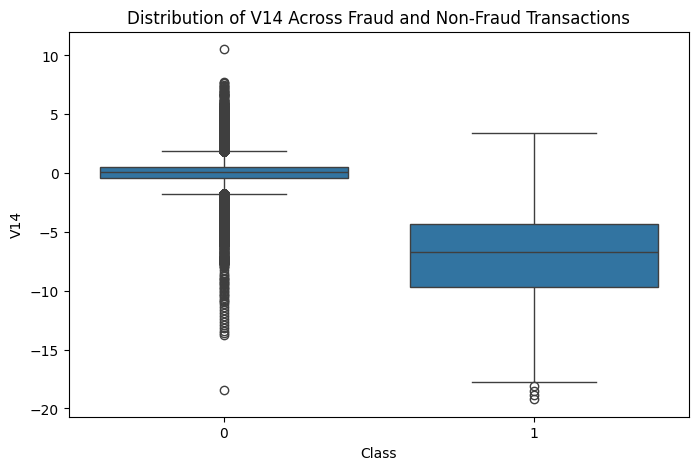

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.boxplot(x=df["Class"], y=df["V14"], data=df)
plt.title("Distribution of V14 Across Fraud and Non-Fraud Transactions")
plt.show()